# Object detection

In this task we are going to train a single shot object detector based on ideas from SSD on a [dataset from kaggle](https://www.kaggle.com/andrewmvd/face-mask-detection) with people wearing face masks.

In [ ]:
# Download the dataset
!wget --quiet --show-progress "https://www.dropbox.com/s/yqjtopocpy6y82e/masks_dataset.tar?dl=1" -O masks_dataset.tar
!tar -xf masks_dataset.tar

masks_dataset.tar   100%[===================>] 397.81M  28.1MB/s    in 15s     


## Data

We already preprocessed data, so it would be easier to work with than the original. All annotations are in `masks_dataset/annotations.json` in the pascal voc format (`x_min`, `y_min`, `x_max`, `y_max`, `cls`). In our case we have two classes -- mask and no mask

In [ ]:
import json
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import albumentations as A
import albumentations.pytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm.auto import tqdm

Standart pytorch data pipeline. We define our custom dataset with `__getitem__` and `__len__` methods to later use for creating training batches. With a bit of work you could change this part to supply your own detection datasets.

In [ ]:
class MasksDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="masks_dataset", train=True, seed=10):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"
        with open(self.root/"annotations.json") as f:
            annotations = np.array(json.load(f))

        np.random.seed(seed)
        permutation = np.random.permutation(len(annotations))

        # Train/test split for later evaluation
        if train:
            self.annotations = annotations[permutation[:int(len(annotations) * 0.8)]].tolist()
        else:
            self.annotations = annotations[permutation[int(len(annotations) * 0.8):]].tolist()



    def __getitem__(self, idx):
        ann = self.annotations[idx]
        image = np.array(Image.open(self.root/ann["folder"]/ann["filename"]))[...,:3]
        bboxes = ann["bboxes"]

        return self.transform(image=image, bboxes=bboxes)

    def __len__(self):
        return len(self.annotations)

This is just a basic resize and normalization. You could experiment more with augmentations to get better quality detections later


In [ ]:
imagenet_stats = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

train_transform = A.Compose(
    [A.Resize(256,256),
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.3)
)

test_transform = A.Compose(
    [A.Resize(256, 256),
     A.pytorch.ToTensor(normalize=imagenet_stats)],
    bbox_params=dict(format='pascal_voc', min_visibility=0.5)
)

In [ ]:
train_ds = MasksDataset(transform=train_transform, train=True)
test_ds = MasksDataset(transform=test_transform, train=False)

Now that we have loaded the data, we need to look at it with our own eyes before training any models. Finish the `visualize` function which takes lists of images and bounding boxes as input and plots this boxes on images. (The format is as described above).

Usefull functions:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- easy to create multiple graphs in one pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- displaying images (dont forget to unnormalize images back)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- for bounding boxes

If you are stuck with this you can take a look [here]()

## Annotated solution

Here we simply use matplotlib patches to draw bounding boxes in colors. We use threshold of $0.5$ throughout the whole notebook to predict if there is object (face in our case) in the cell and to predict it's class (mask or no mask in our case)

In [ ]:
def visualize(images, bboxes):
    fig, axes = plt.subplots(2,len(images)//2 + len(images) % 2, figsize=(10,8),dpi=100)
    for i,ax in enumerate(axes.reshape(-1)):
        ax.axis(False)
        if i >= len(images): break
        ax.imshow(
            images[i].permute(1,2,0) * torch.tensor(imagenet_stats['std'])[None,None,:]
          + torch.tensor(imagenet_stats['mean'])[None,None,:]
        )

        for bbox in bboxes[i]:
            # TODO remove and add instructions
            xmin,ymin,xmax,ymax = bbox[:-1]
            w = xmax-xmin
            h = ymax-ymin
            with_mask = bbox[-1] > 0.2
            c = "green" if with_mask else "red"
            ax.add_patch(patches.Rectangle((xmin,ymin), w,h, fill=False, color=c))
            ax.text(xmin+1,ymin-5, "Mask" if with_mask else "No mask", fontsize=8, color=c)

    fig.tight_layout()
    fig.show()

You should get something like this:

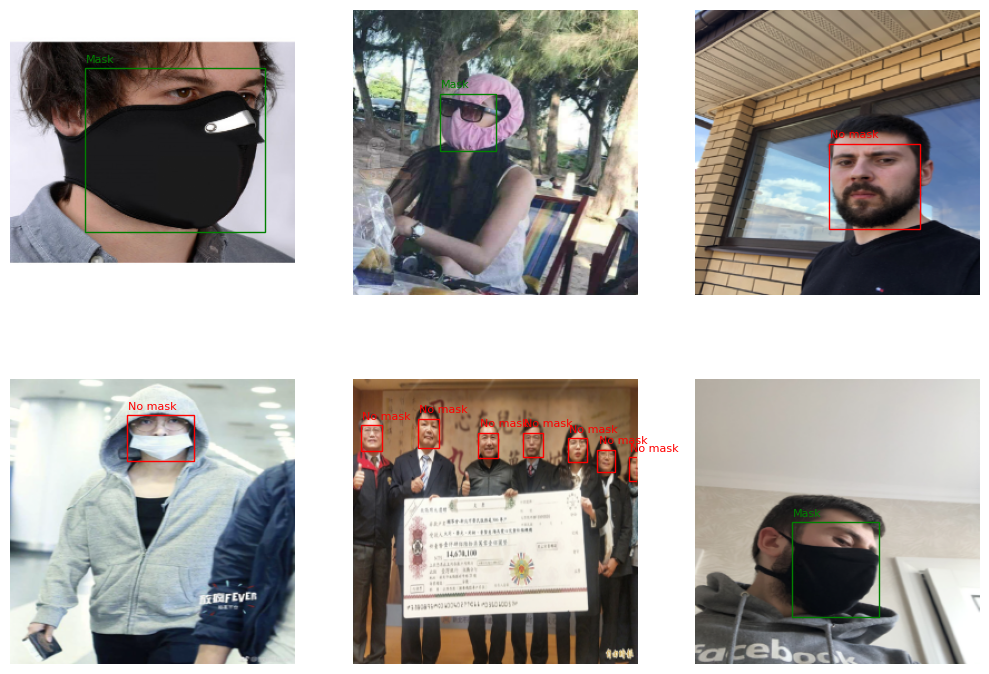

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o['image'] for o in out], [o['bboxes'] for o in out])

## YOLO model

Its time to implement YOLO detector and fine tune it on the masks dataset. This is probably the simplest deep learning detector described in the paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Here we are going to use the resnet backbone for prediction and grid size of $8 \times 8$ (which is the shape of resnet's block 4 for input images of size $256 \times 256$. For each position we would predict 1 bounding box and $1$ number for binary mask on/off prediction.



## Annotated solution
Before implementing model and loss function let's write the collate function. Using collate function with pytorch dataloaders allows us to customize how batch is constructed from examples (see [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) for more details).

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b['image'], b['bboxes']) for b in batch])))

    imgs = torch.stack(imgs)
    b,_,h,w = imgs.shape

    # fill out target for all boxes
    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1))

        # Normalize box height and width for easier prediction
        w_box = (xmax-xmin) / w
        h_box = (ymax-ymin) / h

        # compute bbox centers relative to w//downsample, h//downsample cells
        cx = (xmin + xmax) / 2
        cy = (ymin + ymax) / 2
        cx_idx = cx.div(downsample, rounding_mode='floor').long()
        cy_idx = cy.div(downsample, rounding_mode='floor').long()
        cx_box = (cx % downsample) / downsample
        cy_box = (cy % downsample) / downsample

        target[i, :, cy_idx, cx_idx] = torch.stack([cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes])

    return {'image': imgs, 'target': target}

Below is the visual example of the downsampled grid with boxes and their centers:

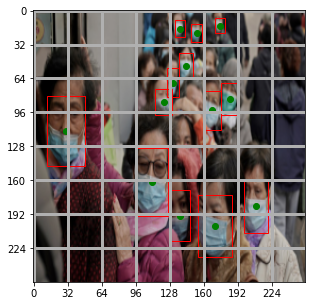

In [ ]:
fig,ax=plt.subplots(figsize=(5,5))
i = 20

img = (train_ds[i]['image'].permute(1,2,0) * torch.tensor(imagenet_stats["std"]).view(1,1,-1) +
         torch.tensor(imagenet_stats["mean"]).view(1,1,-1))
bboxes = torch.tensor(train_ds[i]['bboxes'])

ax.imshow(img);
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-', linewidth=3)

for bbox in bboxes:
    # TODO remove and add instructions
    xmin,ymin,xmax,ymax = bbox[:-1]
    w = xmax-xmin
    h = ymax-ymin
    with_mask = bbox[-1]
    ax.add_patch(patches.Rectangle((xmin,ymin), w,h, fill=False, color="red"))

cx = (bboxes[:,0] + bboxes[:,2])/2
cy = (bboxes[:,1] + bboxes[:,3])/2

ax.scatter(cx,cy, color="green", marker="o")

fig.show()

We apply the same principles to decode the prediction:

* Scale and shift predicted centers
* Scale boxes height and width

In [ ]:
def decode_prediction(pred, upsample=32, th=0.5):
    b,c,h,w = pred.shape
    img_w, img_h = w * upsample, h * upsample

    b_idx, cy_idx, cx_idx = torch.nonzero(pred[:,4] > th, as_tuple=True)
    pred = pred.permute(0,2,3,1).view(b, -1, pred.size(1))
    boxes = pred[pred[:,:,4] > th]

    cx = boxes[:,0] * upsample + cx_idx * upsample
    cy = boxes[:,1] * upsample + cy_idx * upsample

    w = boxes[:,2] * img_w
    h = boxes[:,3] * img_h

    x_min, x_max = cx - w/2, cx + w/2
    y_min, y_max = cy - h/2, cy + h/2
    boxes = torch.stack([x_min, y_min, x_max, y_max, boxes[:, 5]], dim=1)
    return [boxes[b_idx==i] for i in range(b)]


Model is just fixed resnet-50 pretrained on imagenet and a fully-convolutional predictor on top with 6 outputs -- $4$ for coordinates $1$ for objectness prediction and $1$ for class prediction (binary classification)

In [ ]:
class YOLOv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = torchvision.models.resnet50(pretrained=True)
        for p in self.resnet.parameters():
            p.requires_grad = False

        self.predictor = nn.Sequential(
            nn.Conv2d(2048, 256, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 6, 1, 1),
        )

    def forward(self, img):
        x = self.resnet.conv1(img)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        return torch.sigmoid(self.predictor(x))

Yolo loss adapted from the YOLOv1 paper, but instead of MSE on class and objectness predictions we use the logistic loss.

Here we compute classification and box regression losses only for cells that contain objects (this is done via computing `mask` and indexing with it later)

Objectness loss is computed for every cell

In [ ]:
def yolo_v1_loss(pred, target):
    b = target.size(0)
    target = target.permute(0,2,3,1).view(b, -1, 6)
    target_class = target[...,-1]
    target_box   = target[...,:-1]

    mask = target[:,:,4] != 0

    pred = pred.permute(0,2,3,1).view(b,-1, 6)
    pred_class = pred[...,-1]
    pred_box = pred[...,:-1]

    # Binary variable for class (mask on/off)
    class_loss = F.binary_cross_entropy(pred_class, target_class, reduction='sum')
    # Binary variable for each object location (face here or not)
    obj_loss = F.binary_cross_entropy(pred_box[...,-1], target_box[...,-1], reduction='sum')
    # For correct faces predict centers of boxes, width and height
    box_loss = (
        (pred_box[mask][:,:2] - target_box[mask][:,:2])**2 +                          # MSE for center coordinates
        (torch.sqrt(pred_box[mask][:,2:4]) - torch.sqrt(target_box[mask][:,2:4]))**2  # MSE(square roots) for h,w as in yolo
    ).sum()

    # box loss is usually smaller, so we have weight 10 for it

    return (class_loss * 2 + obj_loss + box_loss * 10) / b

Basic train loop follows:

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda:0")

torch.manual_seed(21)
model = YOLOv1().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(5)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        img = batch["image"].to(device)
        target = batch["target"].to(device)

        pred = model(img)
        loss = yolo_v1_loss(pred, target)
        pbar.set_postfix(loss=f"{loss.item():.3f}")
        loss.backward()
        opt.step()
        opt.zero_grad()

        epoch_losses.append(loss.item())

    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Epoch 0 done; Train loss 50.313;


Epoch 1 done; Train loss 27.833;


Epoch 2 done; Train loss 22.042;


Epoch 3 done; Train loss 17.733;


Epoch 4 done; Train loss 15.522;



Now let's run our detector on some test images:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
pred = model(batch["image"].to(device)).cpu().detach()

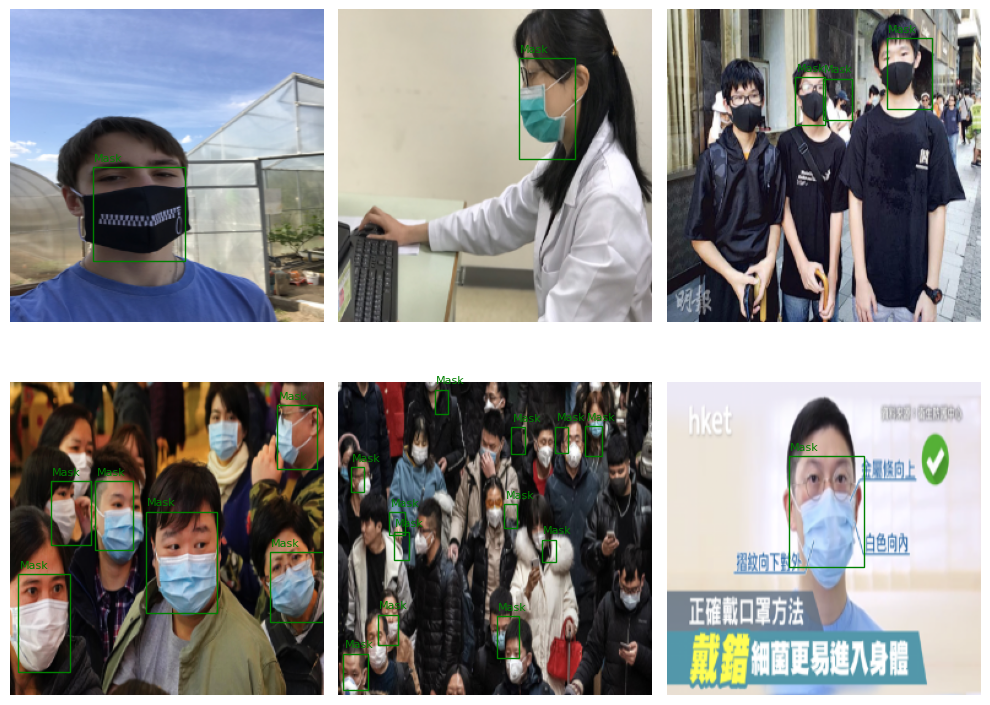

In [ ]:
visualize(batch['image'], decode_prediction(pred))

As we can see detector works well on simple images, but it quickly overfits to the train set (only 600 images), and fails on more complex scenes with many people.

If you are interested in further improvements (like multiple anchors, multilevel features) we recommend you check out these posts:
* https://pytorch.org/blog/torchvision-ssd-implementation
* https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection